In [ ]:
#Loading in Pretrained Model
import sys
import os
sys.version
import keras
from keras import callbacks
from keras import backend as K
from keras.applications import VGG19

vgg19_base = VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

# Loading the VGG19 Pre-Trained Model

In [ ]:
vgg19_base.summary()

# Model V3

## Add Second Hidden Layer and Re Train the last 2 layers of VGG19

### Same architecture as model v2 except using VGG19 instead of VGG16

In [3]:
#Model with Conv Base Included
from keras import models
from keras import layers
from keras import optimizers
model_v3 = models.Sequential()
model_v3.add(vgg19_base)
model_v3.add(layers.Flatten())
model_v3.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model_v3.add(layers.Dropout(0.5))
model_v3.add(layers.Dense(128, activation='relu'))
model_v3.add(layers.Dropout(0.5))
model_v3.add(layers.Dense(10, activation = 'softmax'))

class MyCallback(callbacks.Callback):
    def on_epoch_end(self,epoch,logs=None):
        print(K.eval(self.model.optimizer.lr))
PrintLR=MyCallback()

savebest=callbacks.ModelCheckpoint(filepath='/home/jupyter/Saved_Models/checkpoint-{val_acc:.2f}.h5',monitor='val_acc',save_best_only=True)
ReduceLR=callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, verbose=0, mode='auto', cooldown=20, min_lr=1e-7)
Earlystop = callbacks.EarlyStopping(monitor='val_loss', patience=20)

callbacks_list=[savebest,ReduceLR,PrintLR]

model_v3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total para

In [4]:
# Set last 2 layers of VGG19 as trainable

vgg19_base.trainable = True

set_trainable = False
for layer in vgg19_base.layers:
    if layer.name == 'block5_conv1' or layer.name == 'block4_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
print(len(model_v3.trainable_weights))

22


In [5]:
from keras.utils import multi_gpu_model
parallel_model = multi_gpu_model(model_v3, gpus=2)
parallel_model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

## Splitting Data into Train and Validate Sets (80% Train % 20% Validation)

In [6]:
from keras.preprocessing.image import ImageDataGenerator


base_dir = '/home/jupyter/Data'
train_dir = os.path.join(base_dir, 'train')

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest',
    validation_split=0.2
    )



train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical',
        subset="training",
        shuffle = True
        )

validation_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical',
        subset="validation",
        shuffle = True
        )

Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.


# Run Model V3

In [7]:
history_v2 = parallel_model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=500,
      validation_data=validation_generator,
      validation_steps=50,
      callbacks=callbacks_list,
      #use_multiprocessing = True,
      #workers = 4,
      verbose=2)

print("Finished")

Epoch 1/500
 - 30s - loss: 2.5090 - acc: 0.1075 - val_loss: 2.3016 - val_acc: 0.1100
1e-05
Epoch 2/500
 - 26s - loss: 2.3798 - acc: 0.1030 - val_loss: 2.2971 - val_acc: 0.1170
1e-05
Epoch 3/500
 - 26s - loss: 2.3430 - acc: 0.1110 - val_loss: 2.2895 - val_acc: 0.1290
1e-05
Epoch 4/500
 - 26s - loss: 2.3175 - acc: 0.1100 - val_loss: 2.2926 - val_acc: 0.1270
1e-05
Epoch 5/500
 - 26s - loss: 2.3058 - acc: 0.1125 - val_loss: 2.2787 - val_acc: 0.1498
1e-05
Epoch 6/500
 - 27s - loss: 2.2968 - acc: 0.1310 - val_loss: 2.2729 - val_acc: 0.1380
1e-05
Epoch 7/500
 - 26s - loss: 2.2864 - acc: 0.1305 - val_loss: 2.2450 - val_acc: 0.2240
1e-05
Epoch 8/500
 - 26s - loss: 2.2766 - acc: 0.1275 - val_loss: 2.2128 - val_acc: 0.2000
1e-05
Epoch 9/500
 - 27s - loss: 2.2403 - acc: 0.1500 - val_loss: 2.1564 - val_acc: 0.2192
1e-05
Epoch 10/500
 - 26s - loss: 2.2176 - acc: 0.1445 - val_loss: 2.1281 - val_acc: 0.2120
1e-05
Epoch 11/500
 - 26s - loss: 2.1842 - acc: 0.1650 - val_loss: 2.1245 - val_acc: 0.1620
1e-

# Plot Training and Validation Accuracy of 50 Epoch model 

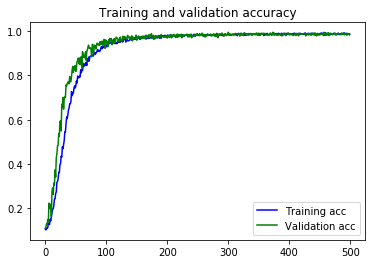

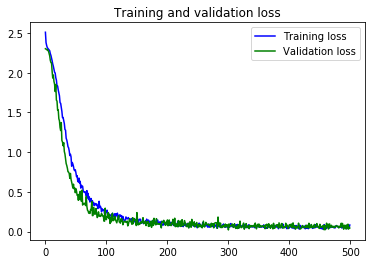

In [12]:
import matplotlib.pyplot as plt
acc = history_v2.history['acc']
val_acc = history_v2.history['val_acc']
loss = history_v2.history['loss']
val_loss = history_v2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Save Model

In [13]:
import model_util as util
model_json = model_v3.to_json()
with open("/home/jupyter/Saved_Models/modelvgg19_500epoch_2CNN_2hidden.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_v3.save_weights("/home/jupyter/Saved_Models/modelvgg19_500epoch_2CNN_2hidden.h5")
print("Saved model to disk")

Saved model to disk


In [16]:
import os
from keras.preprocessing.image import ImageDataGenerator
#test data
base_dir = '/home/jupyter/Data'
test_dir = os.path.join(base_dir, 'test')
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        '/home/jupyter/Data/TEST',
        target_size=(150, 150),
        batch_size=20,
        classes=['test'],  # only data, no labels
        shuffle=False
       )


Found 79727 images belonging to 1 classes.


In [17]:
from model_util import create_submission
create_submission(model_v3,test_generator,'/home/jupyter/Submission/','sample_submissionvgg19_500.csv')

3987/3987 [==============================] - 592s 148ms/step
591.5929071903229


In [ ]:
import time
start = time.time()
probabilities = loaded_model.predict_generator(test_generator, len(test_generator),verbose=1)
end = time.time()
print(end - start)

In [ ]:
output_dir = '/home/jupyter/Submission/'
import pandas as pd
df_prob = pd.DataFrame(probabilities)
df_label = pd.DataFrame(test_generator.filenames[0:79727])
df = pd.concat([df_label,df_prob],axis=1)
df.columns = ['img','c0','c1','c2','c3','c4','c5','c6','c7','c8','c9']
df.head()
df.to_csv(output_dir + 'sample_submission6.csv',index=False)